In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
from PCA_NP import pca_np
import scipy

In [2]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import cv2

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
sam2_checkpoint = "../../sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [5]:
#read all images from the folder
def read_images(folder_images, folder_masks):
    dict_images = {}
    for filename in os.listdir(folder_images):
        img = Image.open(os.path.join(folder_images, filename))
        mask = Image.open(os.path.join(folder_masks, filename.split('.')[0] + '_segmentation.png'))
        if img is not None and mask is not None:
            dict_images[filename.split('.')[0]] = {}
            dict_images[filename.split('.')[0]]['image'] = img
            dict_images[filename.split('.')[0]]['mask'] = mask
            matrices, explained_var_scores = pca_np(np.array(img))
            dict_images[filename.split('.')[0]]['pca'] = (matrices, explained_var_scores)
    return dict_images

In [6]:
folder_images = '../../data/skincancer_new_processed/test/images'
folder_masks = '../../data/skincancer_new_processed/test/masks'

In [7]:
images_dict = read_images(folder_images, folder_masks)

In [8]:
#DEBUGGING PURPOSES
#for i, elem in enumerate(images_dict.items()):
#    print(elem[1]['pca'][1])
#    if i == 0:
#        break

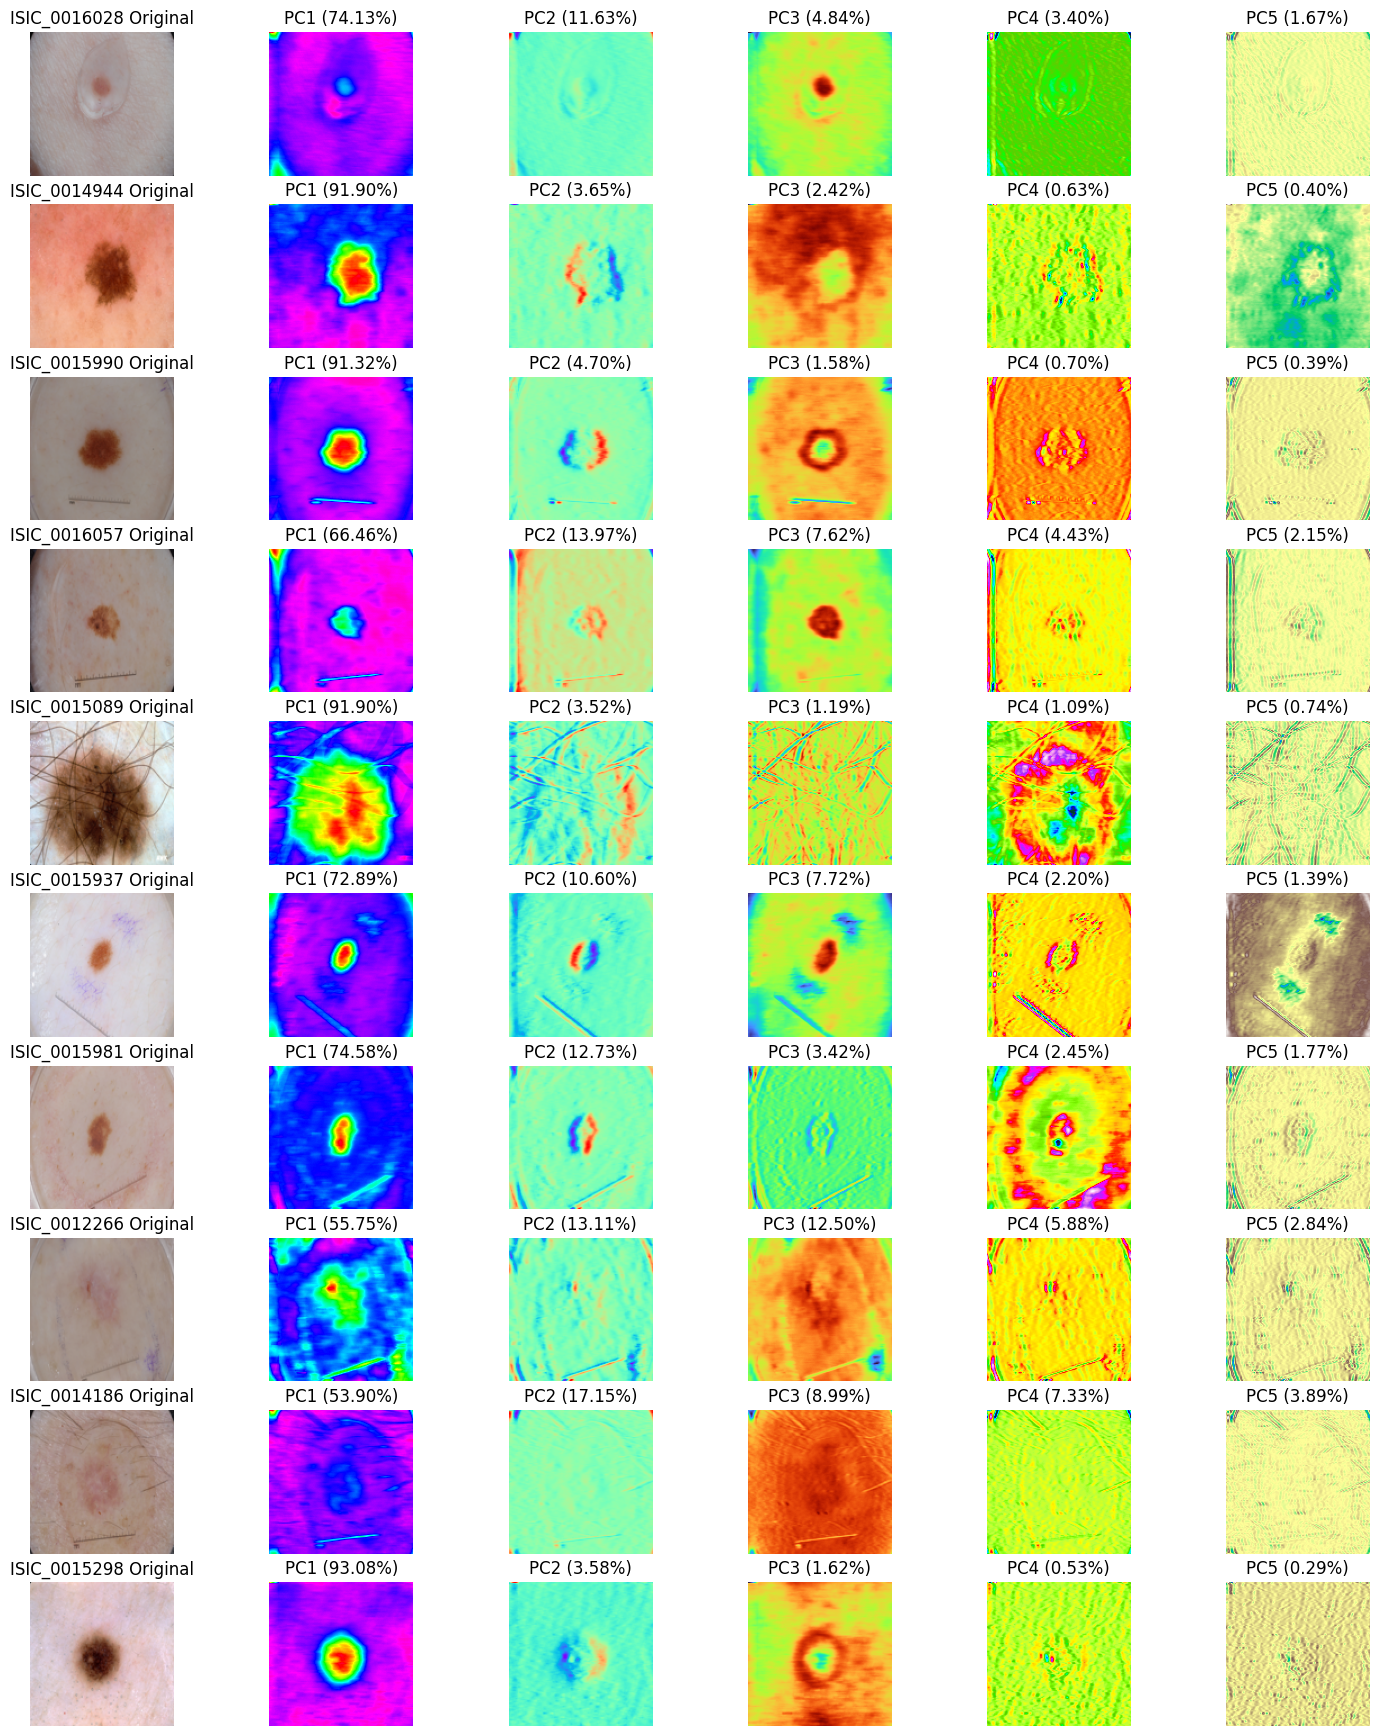

In [9]:
# plot the pca_np image
fig, ax = plt.subplots(10, 6, figsize=(18, 22))
colors = ['gist_rainbow', 'rainbow', 'turbo', 'gist_ncar', 'terrain']
for i, item in enumerate(images_dict.items()):
    if i == 10:
        break
    ax[i, 0].imshow(item[1]['image'])
    ax[i, 0].axis('off')
    ax[i, 0].set_title(item[0] + ' Original')
    for j, matrix in enumerate(item[1]['pca'][0]):
        ax[i, j+1].imshow(matrix, cmap=colors[j])
        ax[i, j+1].axis('off')
        ax[i, j+1].set_title(f'PC{j+1} ({item[1]['pca'][1][j]:.2f}%)')

In [10]:
# function to calculate dice score given two numpy masks
def dice_score(mask1, mask2):
    mask1 = np.asarray(mask1).astype(bool)
    mask2 = np.asarray(mask2).astype(bool)
    intersection = np.sum(mask1 & mask2)
    dice = 2 * intersection / (np.sum(mask1) + np.sum(mask2))
    return dice

# function to calculate the IoU score given two numpy masks
def iou_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    return intersection.sum() / union.sum()

In [11]:
def dual_annealing_best_box(image):
    image = 1 - image
    def loss_function(params):
        x_ld, y_ld, x_ru, y_ru = params
        x1, y1, x2, y2 = int(x_ld), int(y_ld), int(x_ru), int(y_ru)
        
        # Ensure valid box dimensions
        if x1 >= x2 or y1 >= y2:
            return 1e6  # Penalize invalid rectangles
        
        image_cropped = image[y1:y2, x1:x2]
        image_cropped = image_cropped**2
        image_cropped_sum = np.sum(image_cropped)
        sum_image = np.sum(image)
        average_pixel_value = image_cropped_sum / (image_cropped.shape[0] * image_cropped.shape[1])
        box_area = (x2 - x1) * (y2 - y1)

        if box_area == 0:
            return 1e6  # Avoid division by zero

        return -(average_pixel_value**0.5 * np.log(box_area) * sum_image**0.5)  # negative for minimization

    # Define bounds ensuring x_ld < x_ru and y_ld < y_ru
    h, w = image.shape
    bounds = [(10, w - 1), (10, h - 1), (20, w), (20, h)]

    # Perform optimization
    result = scipy.optimize.dual_annealing(loss_function, bounds=bounds, maxiter=100)
    return result

In [12]:
###DEBUGGING PURPOSES
#for i, elem in enumerate(images_dict.items()):
#    #print(elem[1]['pca'][0][0])
#    plt.imshow(1 - elem[1]['pca'][0][0], cmap='gray')
#    plt.show()
#    if i == 0:
#        break

In [13]:
image_name = 'ISIC_0016028'
#image_name = 'ISIC_0015185'

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: -73.45743991272786
       x: [ 6.012e+01  4.006e+01  7.559e+01  5.725e+01]
     nit: 100
    nfev: 841
    njev: 8
    nhev: 0


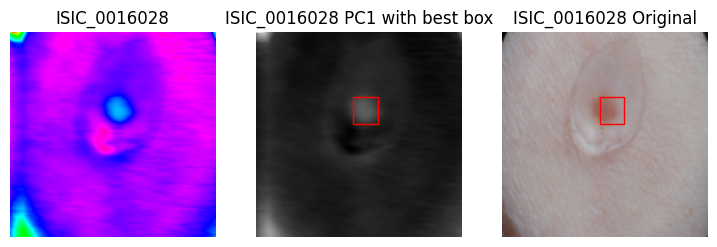

In [27]:
res_dual_annealing = dual_annealing_best_box(image = images_dict[image_name]['pca'][0][0])
print(res_dual_annealing)
# plot the pca_np image and the best box for the first image
fig, ax = plt.subplots(1, 3, figsize=(9, 11))
ax[0].imshow(images_dict[image_name]['pca'][0][0], cmap='gist_rainbow')
ax[0].axis('off')
ax[0].set_title(image_name)
x1, y1, x2, y2 = res_dual_annealing.x
ax[1].imshow(1 - images_dict[image_name]['pca'][0][0], cmap='gray')
ax[1].axis('off')
ax[1].set_title(f'{image_name} PC1 with best box')
rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='r', facecolor='none')
ax[1].add_patch(rect)
# add original image
ax[2].imshow(images_dict[image_name]['image'])
ax[2].axis('off')
ax[2].set_title(f'{image_name} Original')
rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='r', facecolor='none')
ax[2].add_patch(rect)
plt.show()

In [15]:
for i, item in enumerate(images_dict.items()):
    predictor.set_image(np.array(item[1]['image']))
    images_dict[item[0]]['predicted_masks_pca'] = []
    images_dict[item[0]]['dice_scores_predicted_masks_pca'] = []
    images_dict[item[0]]['iou_scores_predicted_masks_pca'] = []
    images_dict[item[0]]['optimized_box'] = []

    pca_1_matrix = item[1]['pca'][0][0]
    #if i == 5:
    #    break
    
    # get the best box for the first pca matrix
    res_dual_annealing = dual_annealing_best_box(image = pca_1_matrix)
    x1, y1, x2, y2 = res_dual_annealing.x
    if x1 - 10 >= 0:
        x1 -= 10
    if x2 + 10 <= 128:
        x2 += 10
    if y1 - 10 >= 0:
        y1 -= 10
    if y2 + 10 <= 128:
        y2 += 10
    box_input = [x1, y1, x2, y2]
    masks, scores, _ = predictor.predict(box = box_input, multimask_output=True)
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    mask = masks[0] # get the first mask
    #mask, _, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=False)
    mask = np.array(mask).astype(np.float32)
    images_dict[item[0]]['predicted_masks_pca'].append(mask)
    # calculate dice and iou scores
    dice = dice_score(np.array(item[1]['mask']), mask)
    iou = iou_score(np.array(item[1]['mask']), mask)
    images_dict[item[0]]['dice_scores_predicted_masks_pca'].append(dice)
    images_dict[item[0]]['iou_scores_predicted_masks_pca'].append(iou)
    images_dict[item[0]]['optimized_box'].append(box_input)

In [16]:
##DEBUGGING PURPOSES
#for i, elem in enumerate(images_dict.items()):
#    print(elem)
#    if i == 0:
#        break

In [22]:
images_names = []
dice_scores_pca1 = []
iou_scores_pca1 = []
for i, elem in enumerate(images_dict.items()):
    images_names.append(elem[0])
    dice_scores_pca1.append(elem[1]['dice_scores_predicted_masks_pca'][0])
    iou_scores_pca1.append(elem[1]['iou_scores_predicted_masks_pca'][0])

In [23]:
df_res = pd.DataFrame({'Image': images_names, 'Dice PCA1': dice_scores_pca1, 'IoU PCA1': iou_scores_pca1})
df_res

Image  Dice PCA1  IoU PCA1
0    ISIC_0016028   0.465312  0.303196
1    ISIC_0014944   0.901105  0.820010
2    ISIC_0015990   0.897713  0.814409
3    ISIC_0016057   0.929099  0.867586
4    ISIC_0015089   0.553248  0.382407
..            ...        ...       ...
595  ISIC_0015215   0.482244  0.317735
596  ISIC_0015142   0.000000  0.000000
597  ISIC_0016015   0.163455  0.089001
598  ISIC_0012722   0.448239  0.288858
599  ISIC_0013814   0.759922  0.612802

[600 rows x 3 columns]

In [24]:
df_res.describe()

Dice PCA1    IoU PCA1
count  600.000000  600.000000
mean     0.583123    0.474930
std      0.310728    0.294074
min      0.000000    0.000000
25%      0.362037    0.221029
50%      0.667104    0.500492
75%      0.846525    0.733891
max      0.985391    0.971203

In [25]:
df_res.to_csv('pca_nb_optimized_results.csv', index=False)

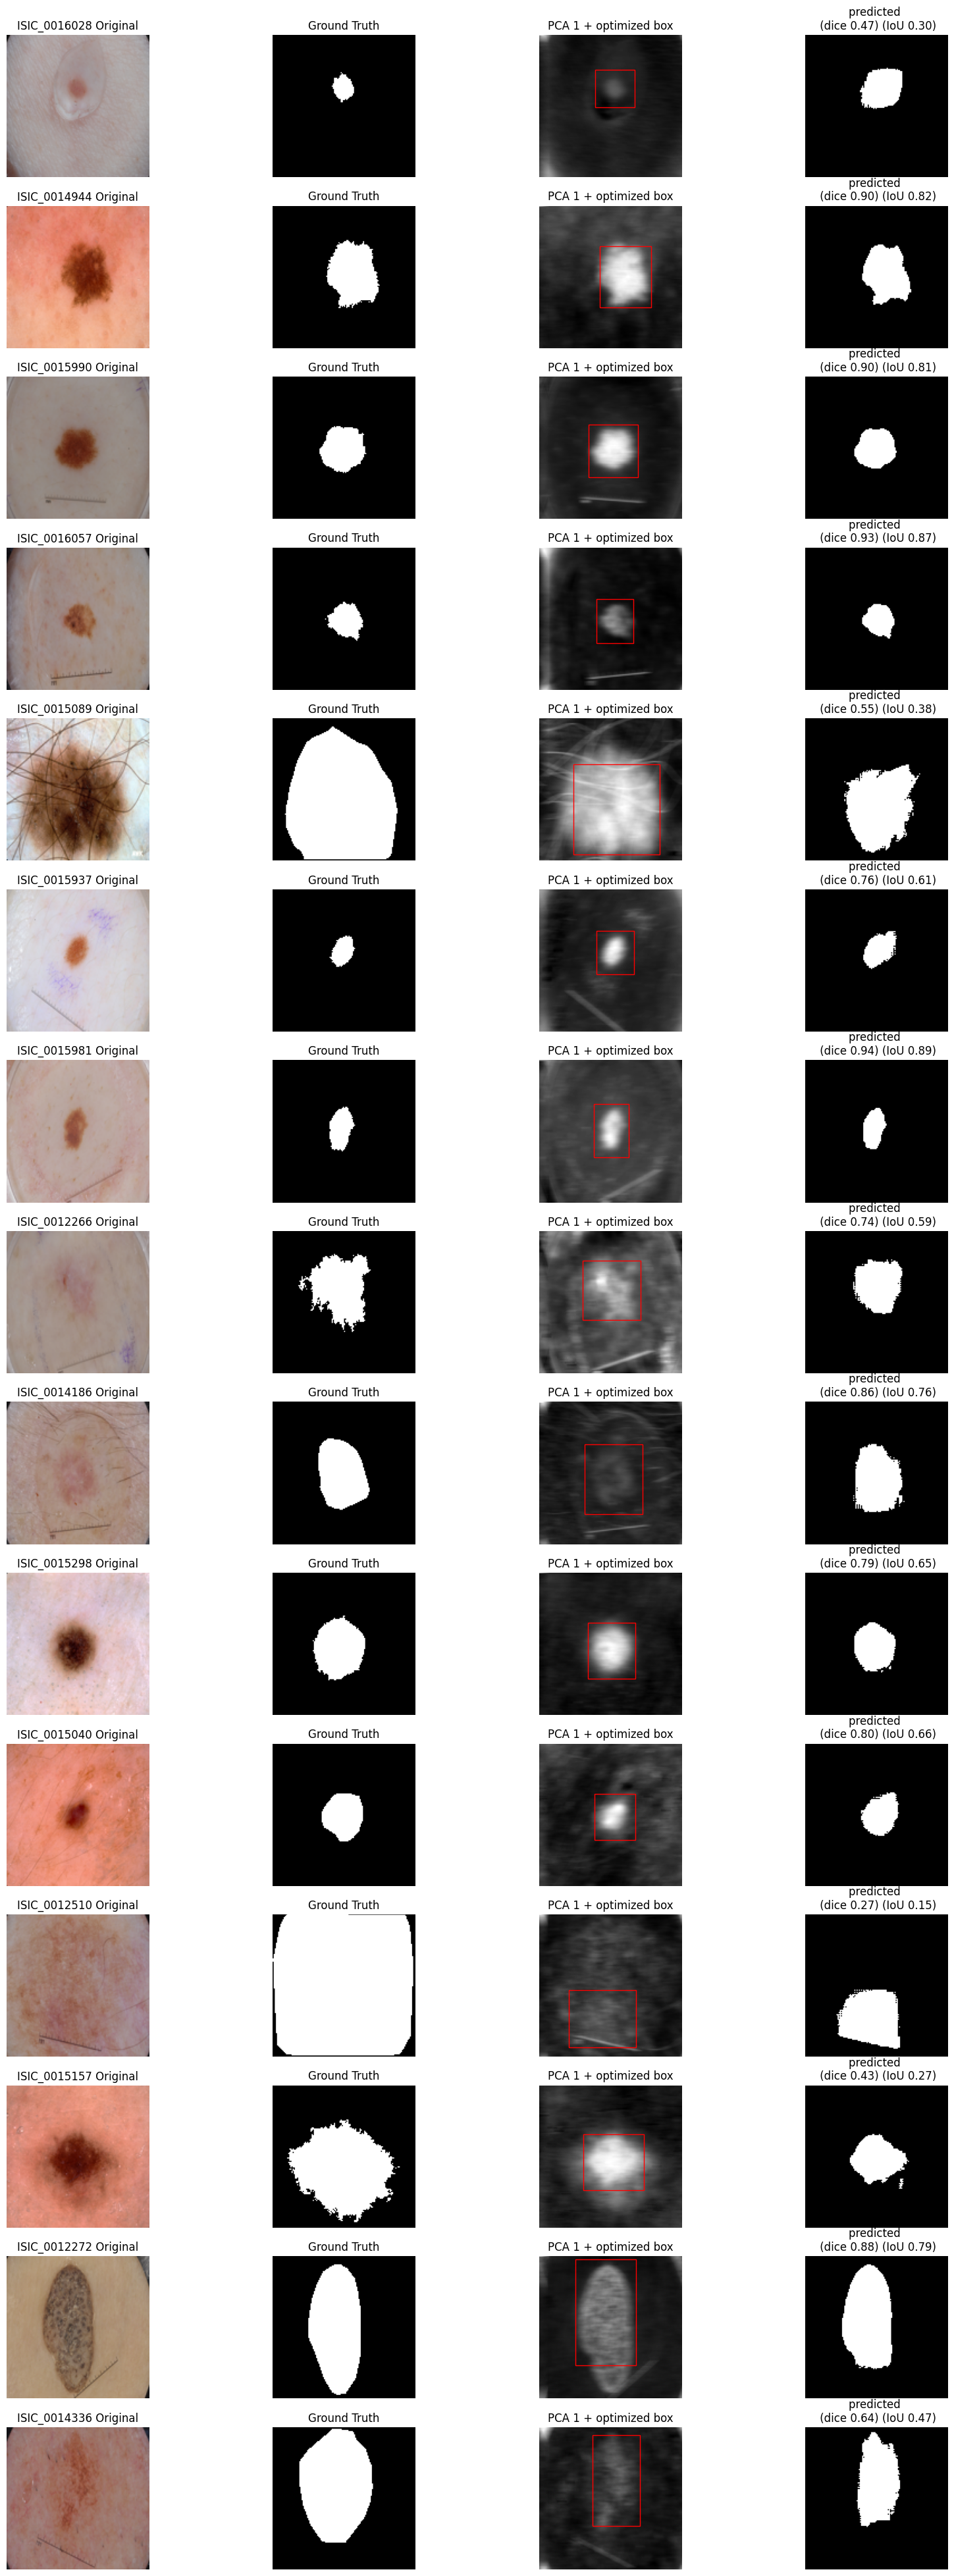

In [26]:
# plot for the first 15 images the mask for each pca component (input)
fig, ax = plt.subplots(15, 4, figsize=(20, 50))
for i, item in enumerate(images_dict.items()):
    if i == 15:
        break
    ax[i, 0].imshow(item[1]['image'])
    ax[i, 0].axis('off')
    ax[i, 0].set_title(item[0] + ' Original')
    ax[i, 1].imshow(item[1]['mask'], cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].set_title('Ground Truth')
    # plot pca1 + box
    pca_1_matrix = 1 - item[1]['pca'][0][0]
    ax[i, 2].imshow(pca_1_matrix, cmap='gray')
    ax[i, 2].axis('off')
    ax[i, 2].set_title('PCA 1 + optimized box')
    box = item[1]['optimized_box'][0]
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='r', facecolor='none')
    ax[i, 2].add_patch(rect)
    predicted = item[1]['predicted_masks_pca'][0]
    ax[i, 3].imshow(predicted, cmap='gray')
    ax[i, 3].axis('off')
    ax[i, 3].set_title(f'predicted \n (dice {item[1]['dice_scores_predicted_masks_pca'][0]:.2f}) (IoU {item[1]['iou_scores_predicted_masks_pca'][0]:.2f})')
    
